# MARKOV CHAIN MONTE CARLO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import lognorm, poisson, norm, beta, binom,uniform 
from rpy2.robjects import r
from rpy2.robjects.packages import importr
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from scipy import integrate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
#from sympy import *
from tabulate import tabulate
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from scipy.special import factorial
import seaborn as sns
from scipy.stats import gamma
from scipy import stats
from scipy.stats import norm
from IPython.display import Image
import random 
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
sns.set()

# 2)

# a) Simulate 200 realizations from the mixture distribution

In [3]:
N = 100000                 

#Sample N random uniforms U
U =uniform.rvs(0, 1, size=200)

#Variable to store the samples from the mixture distribution                                             
#rand.samples = rep(NA,N)
rand_samples=np.zeros(200)
#Sampling from the mixture
for i in range (200):
    if U[i]<=0.3:
        rand_samples[i]=norm.rvs(10,0.5,size=1)
    else:
        rand_samples[i]=norm.rvs(7,0.5,size=1)


Text(0, 0.5, 'Density')

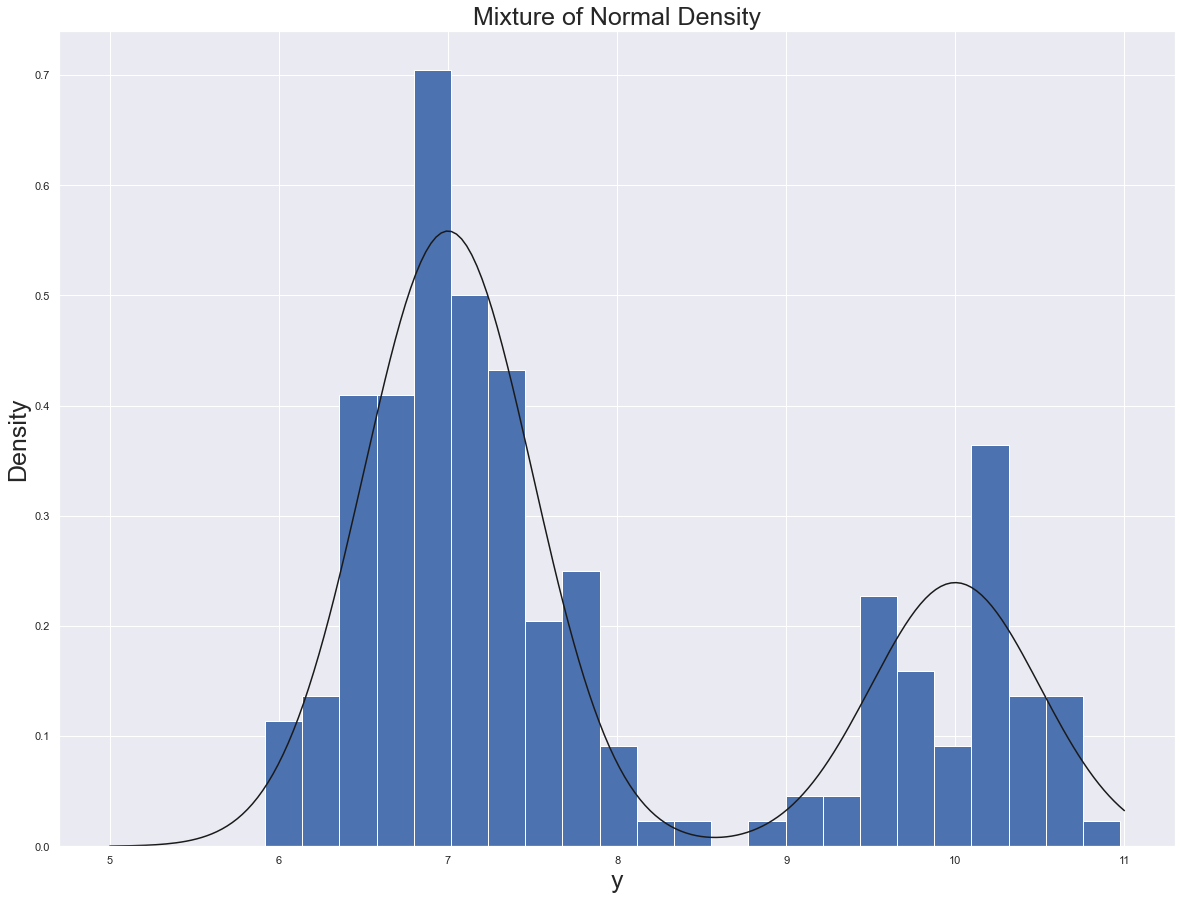

In [7]:
x_ = np.linspace(5,11,200)
delta=0.7
plt.figure(figsize=(20,15))
y_ = delta*norm.pdf(x_,7,0.5) +(1-delta)*norm.pdf(x_,10,0.5)
plt.hist(rand_samples,23,density=True)
plt.plot(x_, y_, 'k-')
plt.title('Mixture of Normal Density',fontsize=25)
plt.xlabel('y',fontsize=25)
plt.ylabel('Density',fontsize=25)

# b) Implement an independence chain MCMC

In [8]:
def f(x):
    return np.prod(x*norm.pdf(rand_samples,7,0.5) +(1-x)*norm.pdf(rand_samples,10,0.5))

In [9]:
def g(x):
    return uniform.pdf(x)

In [10]:
def ratio(xt,x):
    return f(x)*g(xt)/(f(xt)*g(x))

In [11]:
n = 10000
x_val1=np.zeros(n)
x_val1[0]=uniform.rvs(0, 1, size=1)
j_1=n-1
for i in range (0,n-1):
    xt = x_val1[i]
    x = uniform.rvs(0, 1, size=1)
    p = min(ratio(xt,x),1)
    d = binom.rvs(1, p, size=1)
    x_val1[i+1]=x*d + xt*(1-d)
    if x_val1[i+1]==x_val1[i]:
        j_1=j_1-1

In [12]:
print("Acceptance Ratio for Independence chain:", j_1/n*100,'%')

Acceptance Ratio for Independence chain: 10.54 %


# C) Implement a random walk chain

In [4]:
def f_c(x):
    return np.prod(x*norm.pdf(rand_samples,7,0.5) +(1-x)*norm.pdf(rand_samples,10,0.5))

In [5]:
n=10000
j_2 = n-1
_x_ = np.zeros(n)
_x_[0]=0
for i in range (1,n-2):
    eps=np.random.uniform(-1, 1, 1)
    _y_ = _x_[i-1] + eps
    if (_y_ < 0) | (_y_ > 1):
        _x_[i] = _x_[i-1]
        _x_[i]=_y_
    alpha = min(f_c(_y_)/f_c(_x_[i-1]), 1)
    _u_=np.random.uniform(0, 1, 1)
    if _u_ <= alpha:
        _x_[i]=_y_
    else:
        _x_[i]=_x_[i-1]
        j_2=j_2-1

In [13]:
print("Acceptance Ratio for Random walk chain:", j_2/n*100,'%')

Acceptance Ratio for Random walk chain: 4.74 %


# d) Implement a random walk chain with logit transformation

In [14]:
u=np.zeros(n)
u[0]= np.random.uniform(-1, 1,1)
p=np.zeros(n)
p[0]=np.exp(u[0])/(1+np.exp(u[0]))
j_3 = n-1

In [15]:
for i in range (0,n-1):
    u[i+1]=u[i]+np.random.uniform(-1, 1,1)
    p[i+1]=np.exp(u[i+1])/(1+np.exp(u[i+1]))
    R=np.exp(np.log(f(p[i+1]))-np.log(f(p[i])))*np.exp(u[i])/np.exp(u[i+1])
    if (R<1):
        if(binom.rvs(1, R, size=1)==0):
            p[i+1]=p[i]
            u[i+1]=u[i]
            j_3=j_3-1

In [16]:
print("Acceptance Ratio for Random walk chain with logit transformation:", (n-j_3)/n*100,'%')

Acceptance Ratio for Random walk chain with logit transformation: 74.42 %


# Plot the results of different algorithms

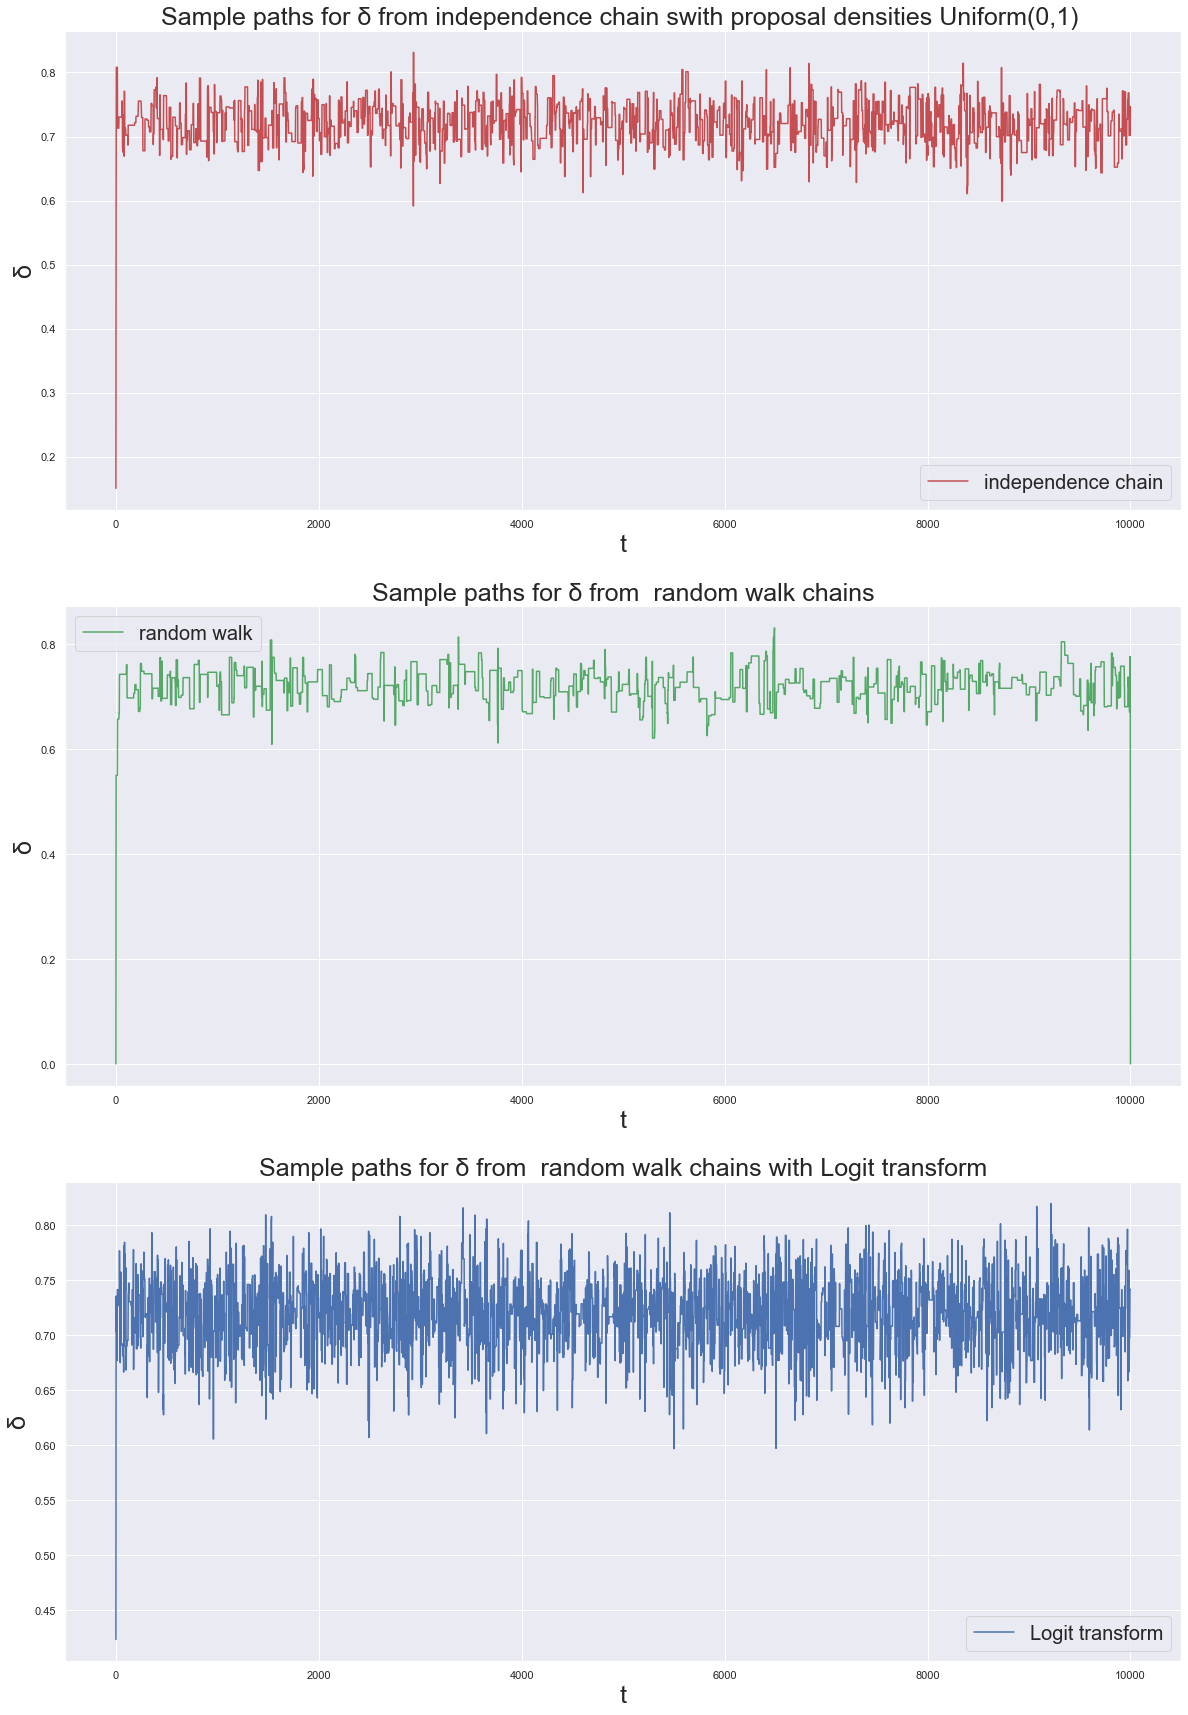

In [17]:
plt.figure(figsize=(20,30))
x1=np.linspace(0,10000,10000)

plt.subplot(3, 1, 1)


plt.plot(x1,x_val1,'r-',label='independence chain')
plt.title('Sample paths for δ from independence chain swith proposal densities Uniform(0,1) ',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)
plt.legend(prop={"size":20})

plt.subplot(3, 1, 2)
plt.plot(x1,_x_,'g-',label='random walk')
plt.title('Sample paths for δ from  random walk chains',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)
plt.legend(prop={"size":20})

plt.subplot(3, 1, 3)
plt.plot(x1,p,'b-',label='Logit transform')
plt.title('Sample paths for δ from  random walk chains with Logit transform',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)
plt.legend(prop={"size":20})

plt.show()

# Summary results of different algorithms

In [18]:
df = pd.DataFrame({'Independence chain':x_val1, 'Random walk':_x_, 'Logit transform':p})
df.describe()

,Independence chain,Random walk,Logit transform
count,10000.000000,10000.000000,10000.000000
mean,0.721358,0.720827,0.719004
std,0.032529,0.033465,0.031343
min,0.150517,0.000000,0.423306
25%,0.697940,0.700435,0.698957
50%,0.720861,0.721276,0.719336
75%,0.744551,0.742615,0.740592
max,0.831522,0.830965,0.819473


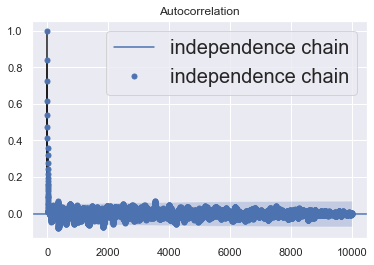

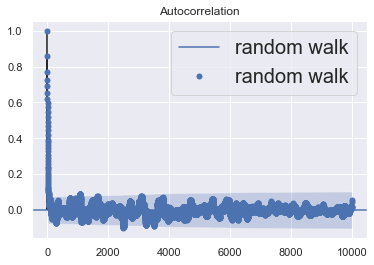

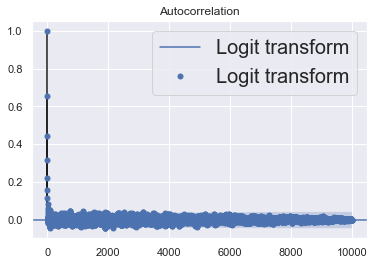

In [35]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Independence chain'].squeeze(), lags=9999,label='independence chain')
plt.legend(prop={"size":20})
sm.graphics.tsa.plot_acf(df['Random walk'].squeeze(), lags=9999,label='random walk')
plt.legend(prop={"size":20})
sm.graphics.tsa.plot_acf(df['Logit transform'].squeeze(), lags=9999,label='Logit transform')
plt.legend(prop={"size":20})
plt.show()

# e) Compare the estimates and convergence behavior of the three algorithms.

### The table says that the mean of all algorithms are close. Further, the mixing ratio for the independence chain is about 10.54% and for random walk chain equals to 4.74%. The reparameterized random walk chain substantionally improves the ratio which is 74.42%.

### From the sample path plots, after burn-in period all algorithms converge and the sample paths wiggle abpit vigorously in the region supported by f. 

### To evaluate the convergence property of the algorithms acf plots have been provided. The plots show that for the reparamerized random walk the autocorrelation decreases rather quickly which means the associated proposal distribution is more appropriate compared to the random walk chan in $\delta$ space with slow decreasing. In addition, independence chain yields an autocorralation that decrease partially quickly. So, for random walk for $\delta$ space mixing is poor, for reparameterized mixing is well. The independence chain has better mixing compared to  random walk bit worse than the reparametterized.

# 2) Simulating from the mixture distribution in Equation (7.6) is straightforward [see part (a) of Problem 7.1]. However, using the Metropolis–Hastings algorithm to simulate realizations from this distribution is useful for exploring the role of the proposal distribution.

# a) Proposal distribution is Normal:

In [36]:
def alpha(x,y):
    return min( 1, (.7*norm.pdf(y,7,.5)+.3*norm.pdf(y,10,.5))/(.7*norm.pdf(x,7,.5)+.3*norm.pdf(x,10,.5)))   

In [82]:
def normal_metro(x0,n):
    r=np.zeros(n)
    x=x0
    for k in range (0,n-1):
        u=uniform.rvs(0,1,1)
        y=norm.rvs(x,0.01,1)
        if u<alpha(x,y):
            x=y
        else:
            x=x0
        r[k]=x
    return r

In [83]:
w_0=normal_metro(0,10000)

Text(0, 0.5, 'δ')

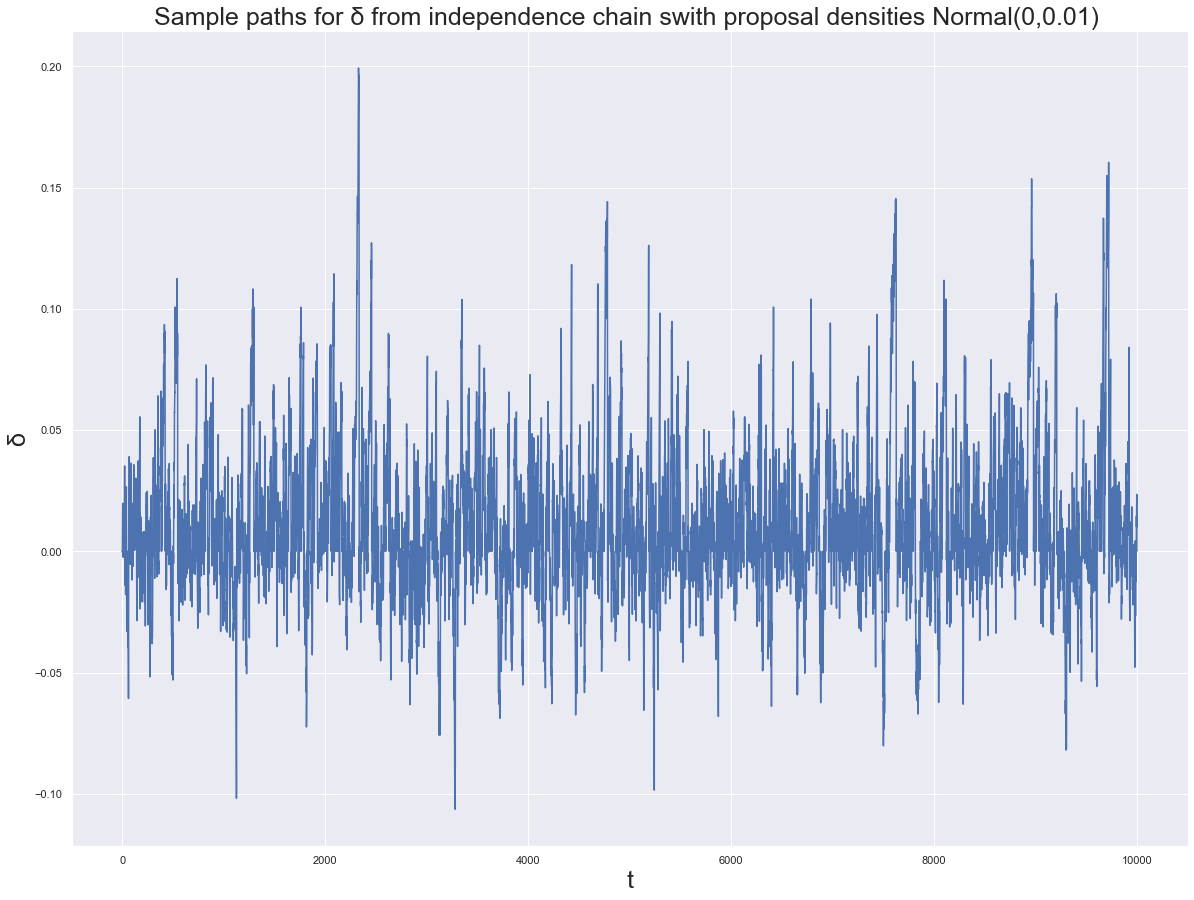

In [84]:
plt.figure(figsize=(20,15))
x1=np.linspace(0,10000,10000)
plt.plot(x1,w_0)
plt.title('Sample paths for δ from independence chain swith proposal densities Normal(0,0.01) ',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)

In [85]:
np.mean(w_0)

0.011151581782874571

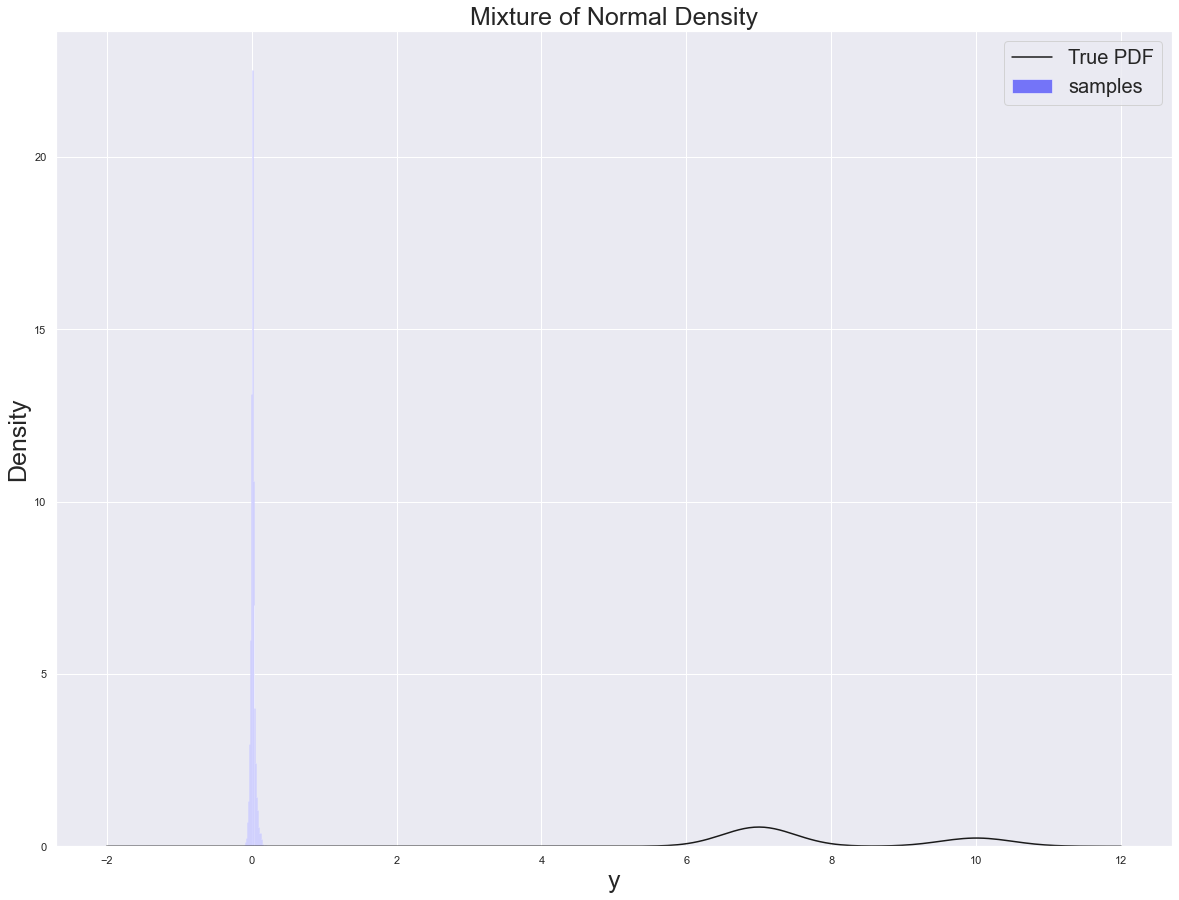

In [95]:
x = np.linspace(-2,12,200)
plt.figure(figsize=(20,15))
#y = norm.pdf(x,7,0.01)
y = delta*norm.pdf(x,7,0.5) +(1-delta)*norm.pdf(x,10,0.5)
#sns.distplot(w_0, color = 'darkgreen',kde=True)
plt.hist(w_0,23,density=True,facecolor='blue', alpha=0.5,label='samples')
#plt.plot(x, norm.pdf(x,0,0.01), 'k-')
plt.plot(x, y, 'k-',label='True PDF')
plt.title('Mixture of Normal Density',fontsize=25)
plt.xlabel('y',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.legend(prop={"size":20})

About the sample path of $N(0,0.01^2)$: 

The resulting chain slowly moves from its starting value and approaches to 0.011. This indicates that the data are sampled from a distribution with mean grater than 0.

In [40]:
w_7=normal_metro(7,10000)

Text(0, 0.5, 'δ')

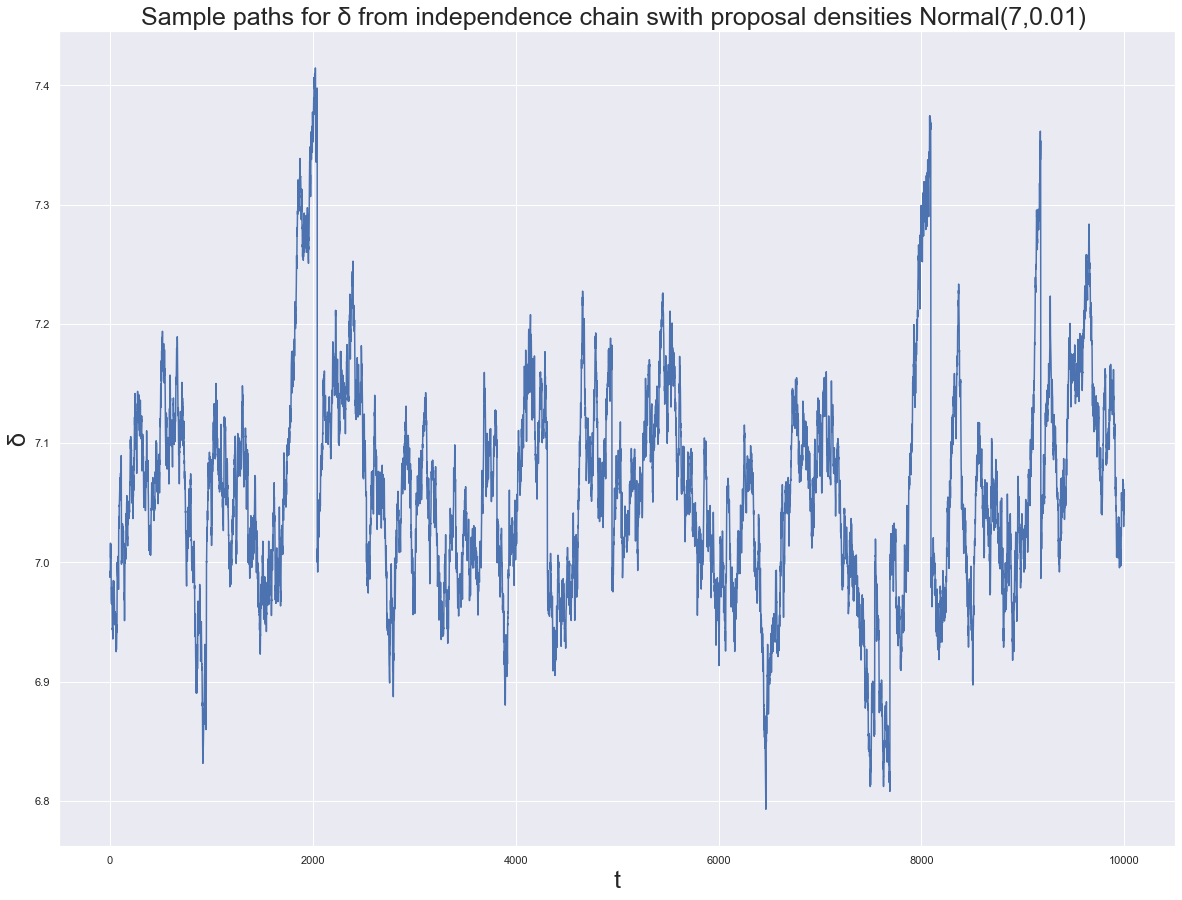

In [66]:
plt.figure(figsize=(20,15))
x1=np.linspace(0,10000,10000)
plt.plot(x1,w_7)
plt.title('Sample paths for δ from independence chain swith proposal densities Normal(7,0.01) ',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)

In [42]:
np.mean(w_7)

7.060383533250244

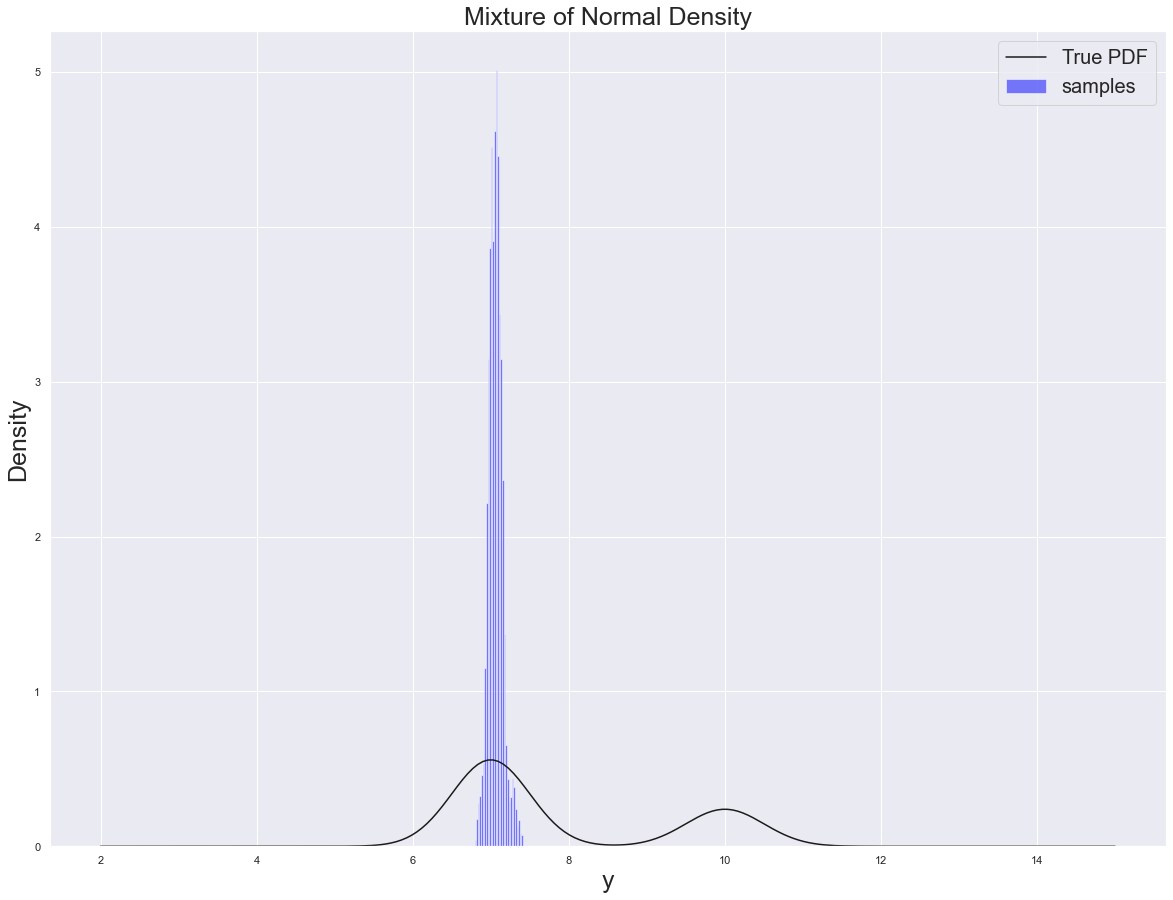

In [97]:
x = np.linspace(2,15,200)
plt.figure(figsize=(20,15))
#y = norm.pdf(x,7,0.01)\
y = delta*norm.pdf(x,7,0.5) +(1-delta)*norm.pdf(x,10,0.5)
plt.hist(w_7,30,density=True,facecolor='blue', alpha=0.5,label='samples')
plt.plot(x, y, 'k-',label='True PDF')
plt.title('Mixture of Normal Density',fontsize=25)
plt.xlabel('y',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.legend(prop={"size":20})

About the sample path of $N(7,0.01^2): 

The resulting path wiggles only around 7 which means the observed data are sampled from the distribution with mean of 7.

In [48]:
w_15=normal_metro(15,10000)

Text(0, 0.5, 'δ')

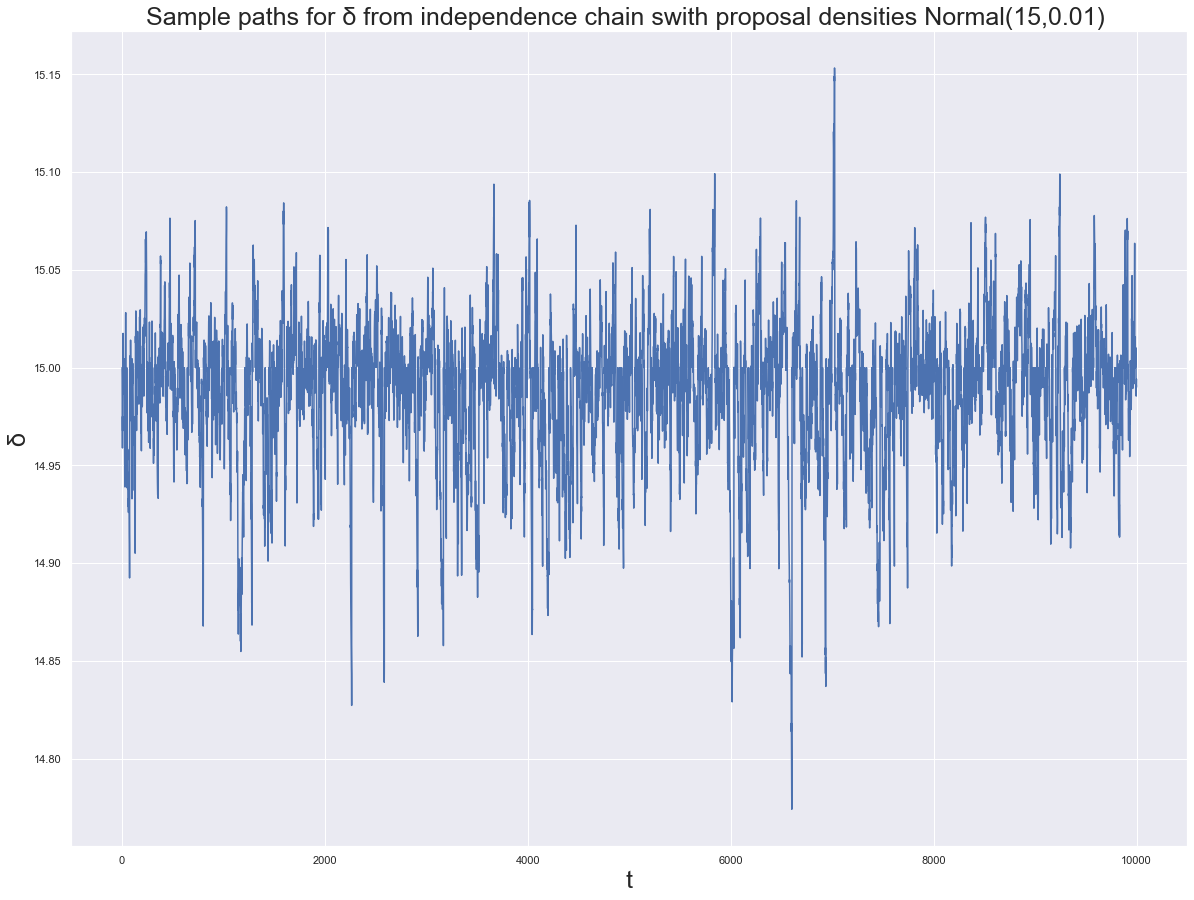

In [68]:
plt.figure(figsize=(20,15))
x1=np.linspace(0,10000,10000)
plt.plot(x1,w_15)
plt.title('Sample paths for δ from independence chain swith proposal densities Normal(15,0.01) ',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)

In [50]:
np.mean(w_15)

14.987980025201058

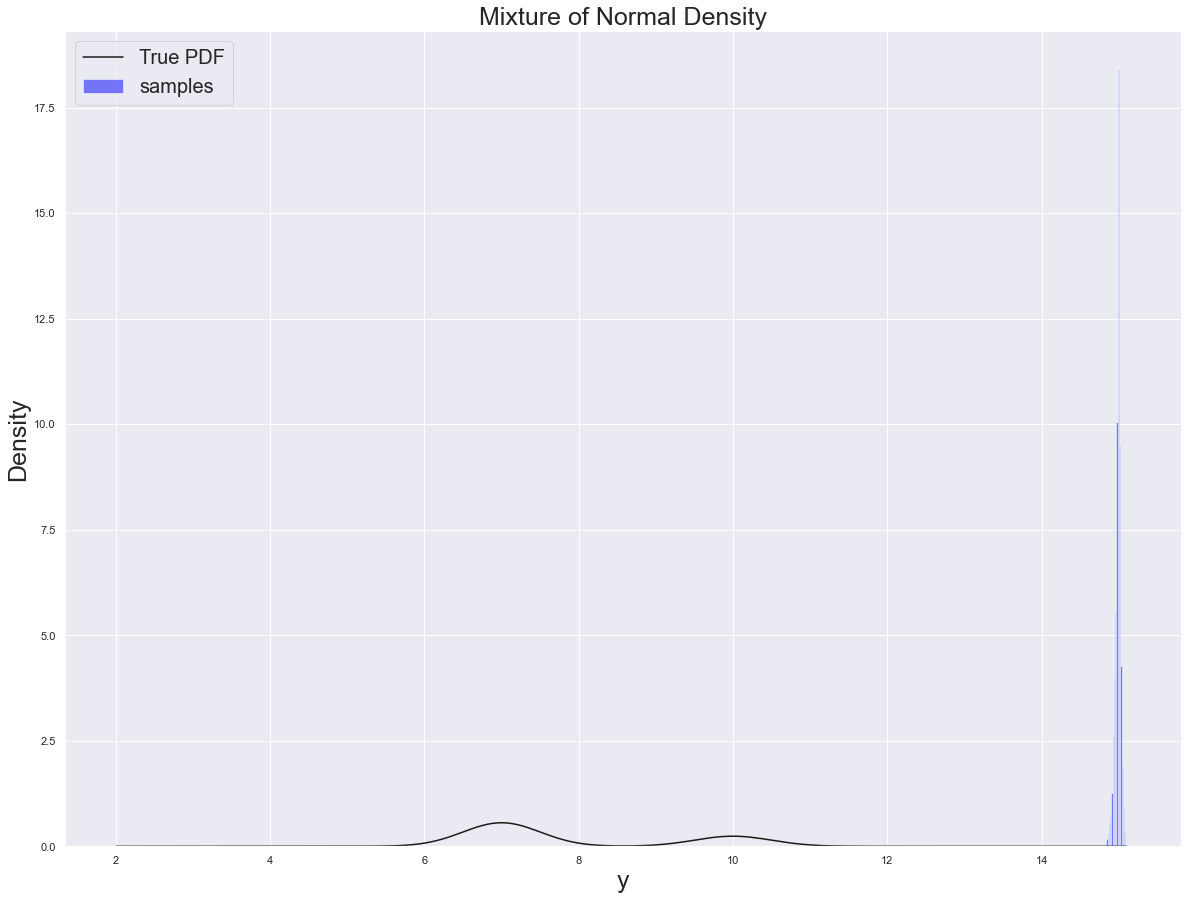

In [98]:
x = np.linspace(2,15.1,200)
plt.figure(figsize=(20,15))
y = delta*norm.pdf(x,7,0.5) +(1-delta)*norm.pdf(x,10,0.5)
plt.hist(w_15,23,density=True,facecolor='blue', alpha=0.5,label='samples')
plt.plot(x, y, 'k-',label='True PDF')
plt.title('Mixture of Normal Density',fontsize=25)
plt.xlabel('y',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.legend(prop={"size":20})

### About the sample path of $N(15,0.01^2): 

### The resulting path wiggles only around 15 which means the observed data are sampled from the distribution with mean greater than 10.

# b) We will change the proposal distribution N(x,1)

## All the chain move slowly due to $\sigma^2=0.01$. That is, the chains take very small steps at each iteration. So we will use  $\sigma^2=1$

In [99]:
def normal_metro_new(x0,n):
    r=np.zeros(n)
    x=x0
    for k in range (0,n):
        u=uniform.rvs(0,1,1)
        y=norm.rvs(x,1,1)
        if u<alpha(x,y):
            x=y
        else:
            x=x0
        r[k]=x
    return r

In [100]:
w_7_new=normal_metro_new(7,10000)

Text(0, 0.5, 'δ')

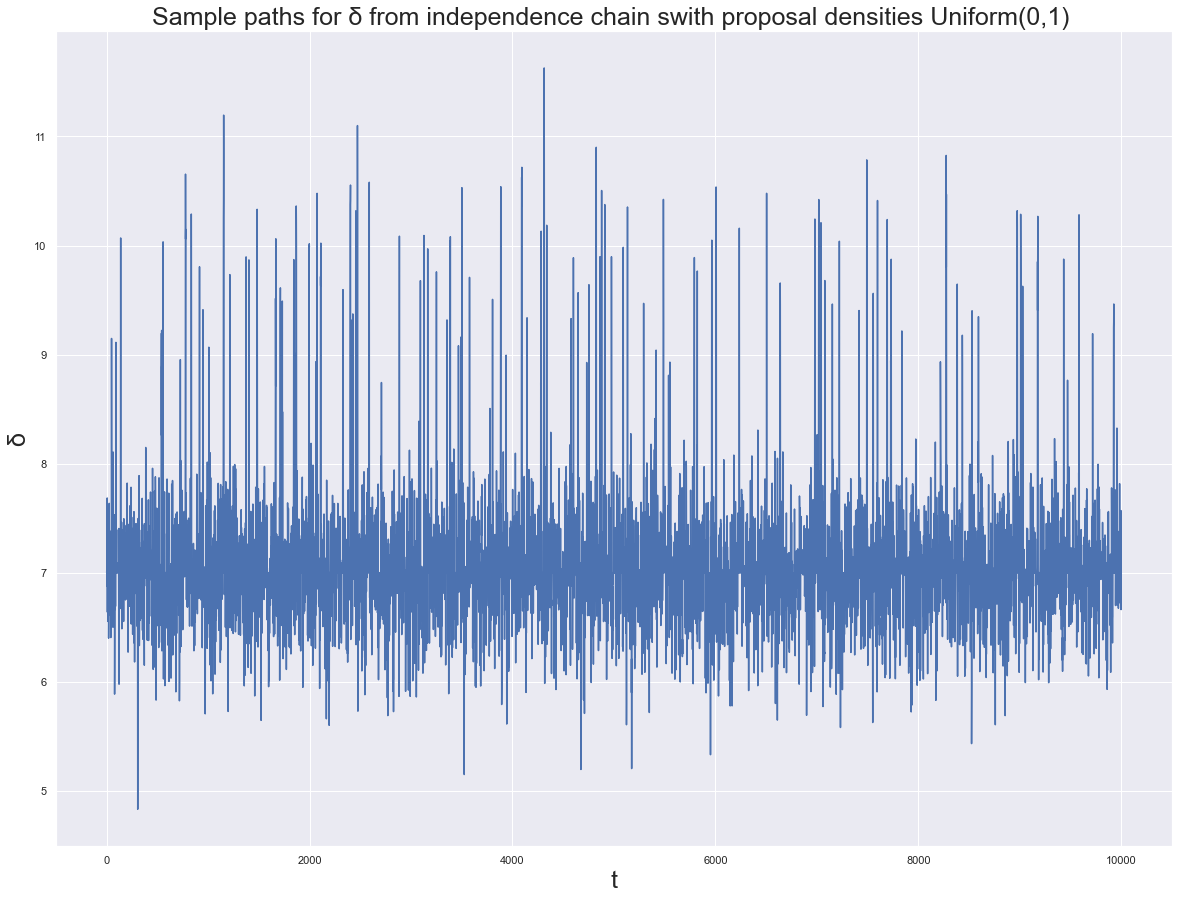

In [101]:
plt.figure(figsize=(20,15))
x1=np.linspace(0,10000,10000)
plt.plot(x1,w_7_new)
plt.title('Sample paths for δ from independence chain swith proposal densities Uniform(0,1) ',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.ylabel('δ',fontsize=25)

In [102]:
np.mean(w_7_new)

7.063118076631819

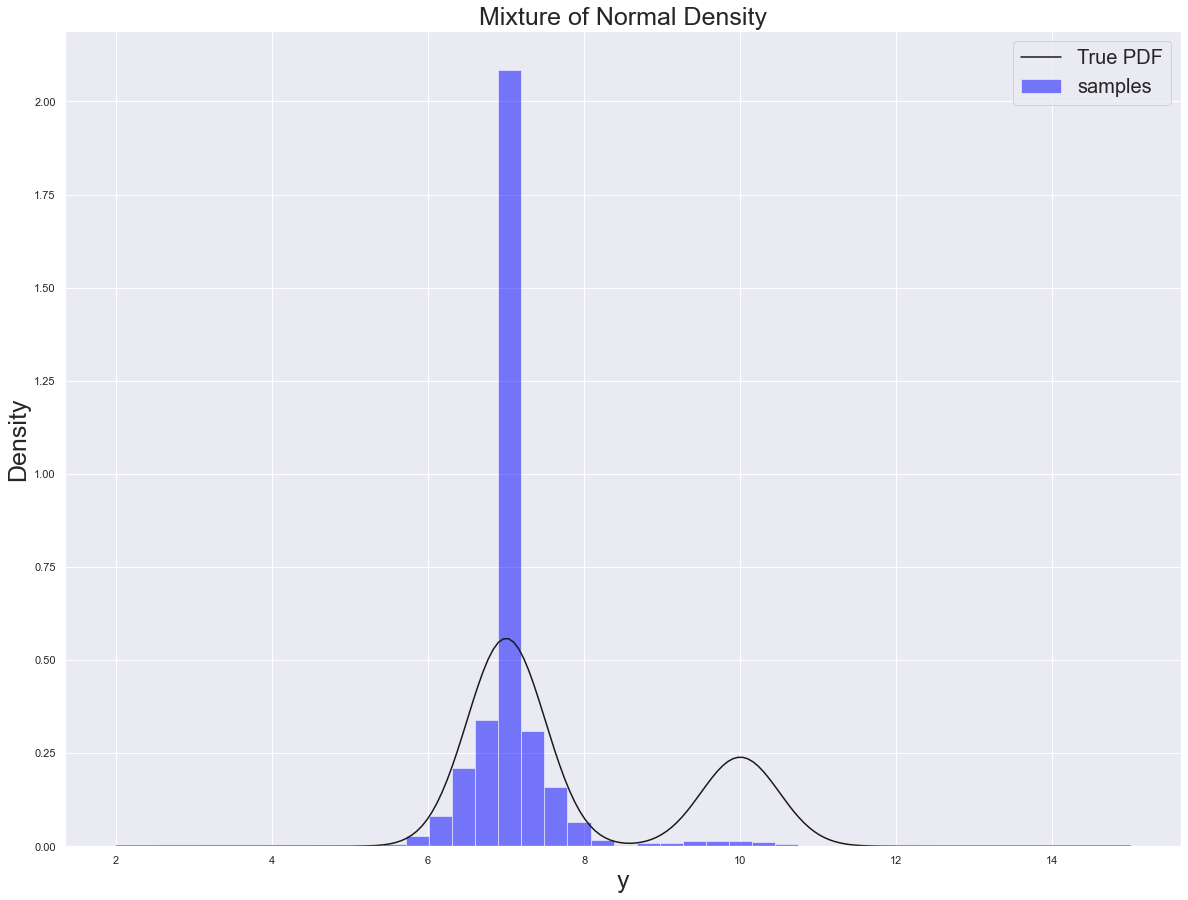

In [104]:
x = np.linspace(2,15,200)
plt.figure(figsize=(20,15))
delta=0.7
y = delta*norm.pdf(x,7,0.5) +(1-delta)*norm.pdf(x,10,0.5)
#y = norm.pdf(x,7,0.01)
plt.hist(w_7_new,23,density=True,facecolor='blue', alpha=0.5,label='samples')
plt.plot(x, y, 'k-',label='True PDF')
plt.title('Mixture of Normal Density',fontsize=25)
plt.xlabel('y',fontsize=25)
plt.ylabel('Density',fontsize=25)
plt.legend(prop={"size":20})